## The objective is to develop a model for binary classification and evaluate its capabilities.
The dataset from scikit_learn is the `make_moons` dataset where the input values represent one of two moons denoted by separate colors. The model developed will attempt to predict the right class.
- Visualize the dataset
- Label the color for each class

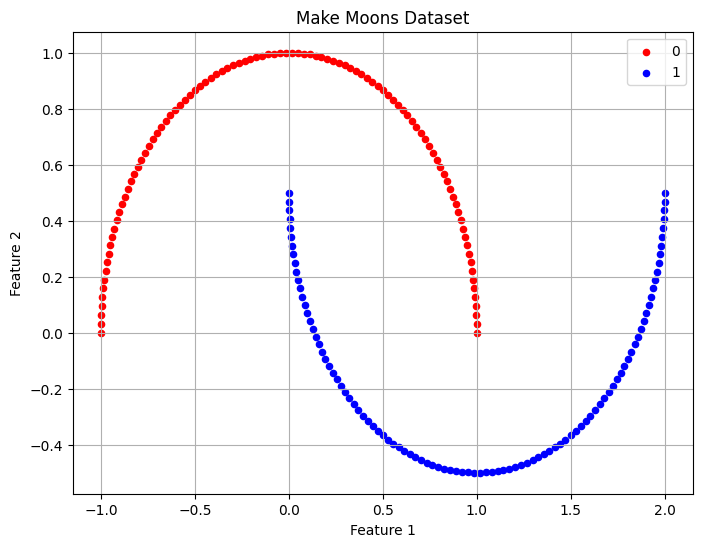

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons

# 1. Generate the make_moons dataset
# X contains the features (coordinates), y contains the labels (0 or 1 for each moon)
X, y = make_moons(n_samples=200, random_state=42)

# 2. Optional: Convert to a Pandas DataFrame for easier handling
df = pd.DataFrame(dict(x=X[:, 0], y=X[:, 1], label=y))

# 3. Visualize the data using a scatter plot
colors = {0: 'red', 1: 'blue'} # Define colors for the two classes
fig, ax = plt.subplots(figsize=(8, 6)) # Create a figure and axis

grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

plt.title('Make Moons Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

### Settings for model

In [10]:
import torch
import torch.nn as nn

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert to tensors
X = torch.from_numpy(X).float().to(device)
y = torch.from_numpy(y).float().to(device)

# Device information
print(f"Data is stored in {device}")

Data is stored in cpu


### Split the data for training and testing

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")

Training data size: 160
Testing data size: 40


### Hyperparameters for model are as follows:

In [16]:
input_dim = len(X[0])
print(f"Dimensions for X: {input_dim}")

output_dim = 1
hidden_units_1 = 10
hidden_units_2 = 5

print(f"Classification labels are: {torch.unique(y)}")
out_dim = len(torch.unique(y))

Dimensions for X: 2
Classification labels are: tensor([0., 1.])


### Create a class for the binary classification model

In [17]:
# Define a class named model that inherits nn.Module which is the base class for ALL neural networks from PyTorch
class model(nn.Module):
    # Initiate the model
    def __init__(self, input_dim, output_dim, hidden_units_1, hidden_units_2):
        # Call the constructor of nn.Module
        super(model, self).__init__()
        self.layer = nn.Sequential(nn.Linear(input_dim, hidden_units_1),
                                   nn.ReLU(),
                                   nn.Linear(hidden_units_1, hidden_units_2),
                                   nn.ReLU(),
                                   nn.Linear(hidden_units_2, output_dim),
                                   nn.ReLU())   
    def forward(self, x):
        x = self.layer(x)
        return x

model = model(input_dim, output_dim, hidden_units_1, hidden_units_2)

### Functions for model

In [18]:
import torch.optim as optim

# Loss function recommended for binary classification that requires the logits passed
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer calculates the gradient of the individual parameters with the loss finding out how much each parameter contirbutes to the loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Accuracy function 
def accuracy(y_predicted, y_actual):
    total = len(y_actual)
    correct = torch.eq(y_predicted, y_actual).sum().item()
    acc = (correct/total) * 100
    return acc

### Architecture of Model
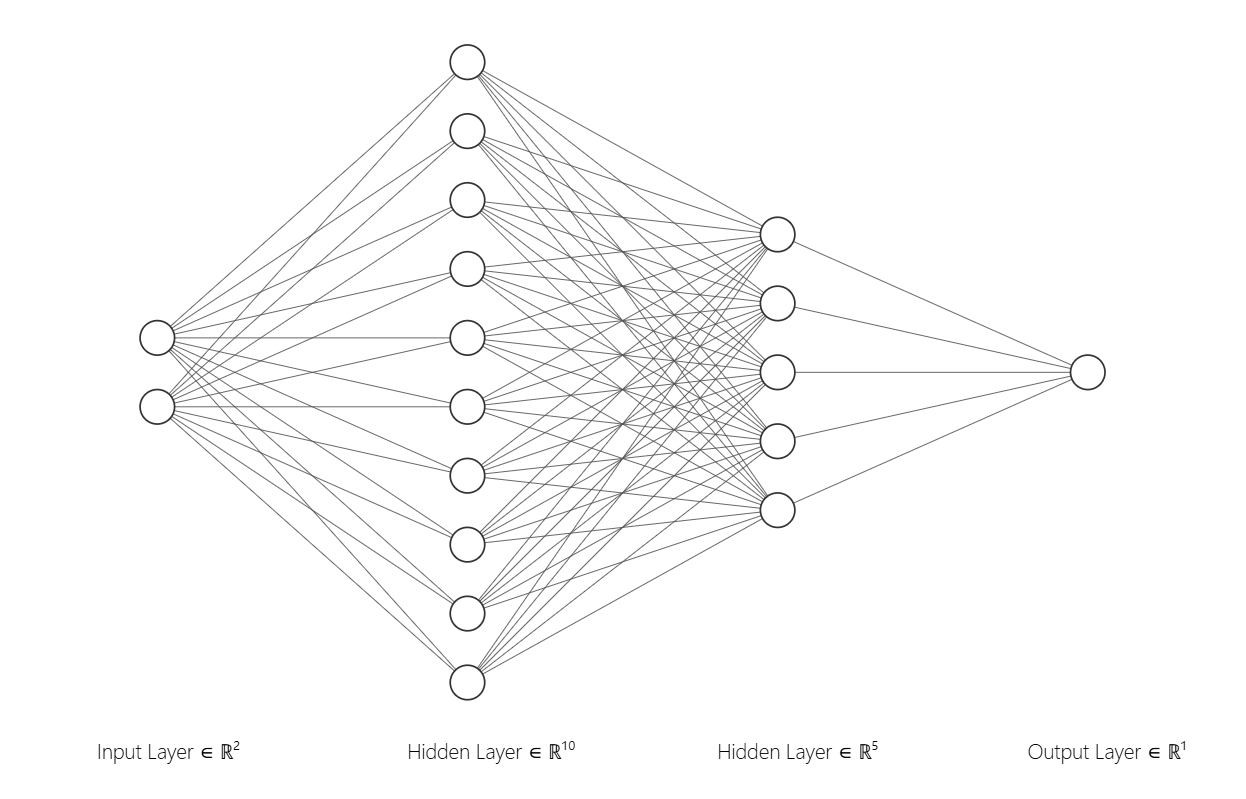

### Create a training and testing loop for binary classification model

In [19]:
train_losses = []
test_losses = []
epoch_count = []

epochs = 1000

### TRAINING MODE
model.train()
for epoch in range(epochs):
    epoch_count.append(epoch)
    
    # Get prediction for training data
    y_logits_train = model(X_train).squeeze()                      # convert to logits
    y_prob_train = torch.sigmoid(y_logits_train)         # probability for trainign data
    y_pred_train = torch.round(y_prob_train)             # get prediction as either 0/1
    
    # Calculate loss and accuracy for prediction
    train_loss = loss_fn(y_logits_train, y_train)
    train_losses.append(train_loss)
    train_acc = accuracy(y_pred_train, y_train)
    
    # Zero the optimzier to clear the gradients for every epoch
    optimizer.zero_grad()
    
    # Backpropagation to find out how much each parameter contributes to the gradient
    train_loss.backward()
    
    # Update parameters
    optimizer.step()
    
    ### TESTING MODE
    model.eval()
    with torch.inference_mode():
        y_logits_test = model(X_test).squeeze()      # convert to logits
        y_prob_test = torch.sigmoid(y_logits_test)   # get probabilites for all classes
        y_pred_test = torch.round(y_prob_test)       # get prediction as either 0/1
        
        # Calculated loss and accuracy for prediction
        test_loss = loss_fn(y_logits_test, y_test)
        test_losses.append(test_loss)
        test_acc = accuracy(y_pred_test, y_test)
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch:{epoch+1} | Training Loss:{train_loss} | Training Accuracy:{train_acc} | Testing Loss:{test_loss} | Testing Accuracy:{test_acc}")

Epoch:100 | Training Loss:0.5771023631095886 | Training Accuracy:78.125 | Testing Loss:0.586249053478241 | Testing Accuracy:82.5
Epoch:200 | Training Loss:0.5183579921722412 | Training Accuracy:84.375 | Testing Loss:0.5303950905799866 | Testing Accuracy:90.0
Epoch:300 | Training Loss:0.4795309603214264 | Training Accuracy:87.5 | Testing Loss:0.5024285912513733 | Testing Accuracy:92.5
Epoch:400 | Training Loss:0.45262089371681213 | Training Accuracy:90.0 | Testing Loss:0.4819543957710266 | Testing Accuracy:92.5
Epoch:500 | Training Loss:0.4274798035621643 | Training Accuracy:93.125 | Testing Loss:0.4596894383430481 | Testing Accuracy:95.0
Epoch:600 | Training Loss:0.3996815085411072 | Training Accuracy:94.375 | Testing Loss:0.4354601800441742 | Testing Accuracy:97.5
Epoch:700 | Training Loss:0.3767028748989105 | Training Accuracy:95.625 | Testing Loss:0.4164019227027893 | Testing Accuracy:97.5
Epoch:800 | Training Loss:0.36257752776145935 | Training Accuracy:96.25 | Testing Loss:0.40544

### To visualize, the predictions for classification, let's use a Confusion Matrix for both on the train and test sets.

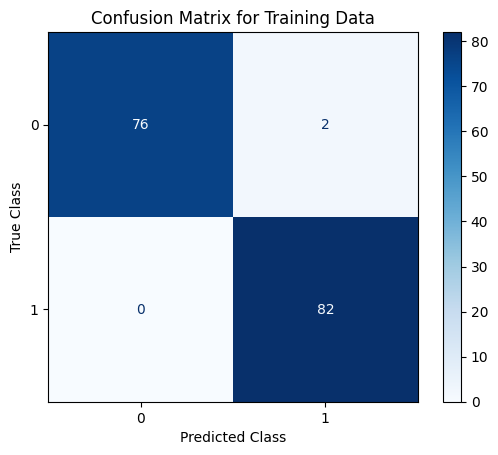

None


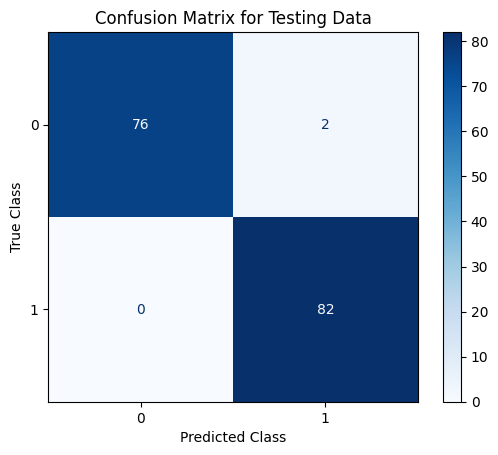

None


In [20]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title, labels=[0, 1]):
    """
    Computes and plots the confusion matrix.
    
    Args:
        y_true: Ground truth labels (tensor or numpy array).
        y_pred: Predicted labels (tensor or numpy array).
        labels: List of class labels (default is [0, 1]).
          title (str): Title for the confusion matrix plot. Default is "Confusion Matrix".
    """
    # If tensors, detach and convert to numpy arrays
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    
    # Label the axes and set the title
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Plot the confusion matrix
train = plot_confusion_matrix(y_train, y_pred_train, "Training Data")
print(train)
test = plot_confusion_matrix(y_train, y_pred_train, "Testing Data")
print(test)